# GAN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
import torch
from fastai.vision.all import *
from fastai.vision.gan import *
from torch import nn
from torch.utils.data import Dataset
import random
import matplotlib.pyplot as plt
import torch.optim as optim
from fastai.optimizer import Adam



In [3]:
print(fastai.__version__) # version check

2.7.15


### Data

In [4]:
embedding = torch.load('embedding.pkl')

In [5]:
class Txt2ImgDataset(Dataset):
    def __init__(self, items, embedding=embedding):
        self.items = items
        self.embedding = embedding

    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        fn = self.items[idx]
        key = fn.name.split('.')[0] + '.txt'
        
        if key not in self.embedding:
            # Handle case where embedding for key is not found
            print(f"Embedding not found for key: {key}")
            return None
        
        emb = self.embedding[key]
        img = PILImage.create(fn).resize((128, 128))  # Ensure the image is resized to 128x128
        wrong_img = self.get_wrong_image(idx)
        noise = torch.randn(100, 1, 1)
        emb_with_noise = torch.cat([emb, noise], 0)
        return emb, tensor(img).permute(2, 0, 1).float() / 255.0, emb_with_noise, tensor(wrong_img).permute(2, 0, 1).float() / 255.0, fn.name

    def get_wrong_image(self, idx):
        cat = '_'.join(self.items[idx].name.split('_')[:-3])
        wrong_idx = random.choice(range(len(self.items)))
        while '_'.join(self.items[wrong_idx].name.split('_')[:-3]) == cat:
            wrong_idx = random.choice(range(len(self.items)))
        wrong_fn = self.items[wrong_idx]
        wrong_img = PILImage.create(wrong_fn).resize((128, 128))  # Ensure the wrong image is resized to 128x128
        return wrong_img


In [6]:
def verify_dataset(dataset, num_samples=5):
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        sample = dataset[idx]
        
        if sample is None:
            continue
        
        emb, img, emb_with_noise, wrong_img, img_name = sample
        
        print(f"Sample {i + 1} - Image: {img_name}")
        print(f"Embedding shape: {emb.shape}")
        print(f"Image shape: {img.shape}")
        print(f"Embedding with noise shape: {emb_with_noise.shape}")
        print(f"Wrong image shape: {wrong_img.shape}")
        
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(img.permute(1, 2, 0))
        axs[0].set_title("Correct Image")
        axs[1].imshow(wrong_img.permute(1, 2, 0))
        axs[1].set_title("Wrong Image")
        plt.show()


In [7]:
### DataBlock and DataLoaders
def get_dls(path, bs):
    items = get_image_files(path)
    dset = Txt2ImgDataset(items)
    return DataLoaders.from_dsets(dset, dset, bs=bs)

dls = get_dls('data/images/train', bs=128)

Sample 1 - Image: Gray_Catbird_0027_20968_2.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


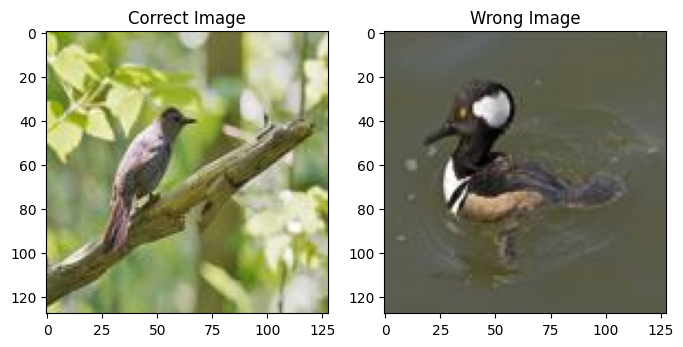

Sample 2 - Image: Fish_Crow_0034_25891_3.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


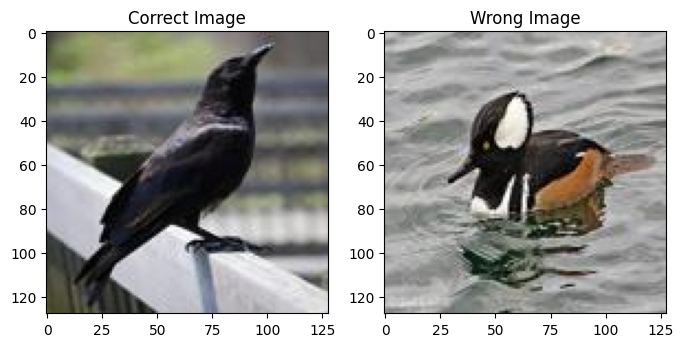

Sample 3 - Image: Ivory_Gull_0035_49523_1.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


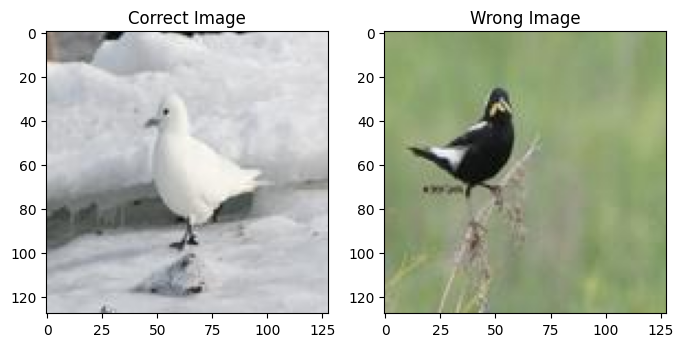

Sample 4 - Image: Ivory_Gull_0093_49052_3.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


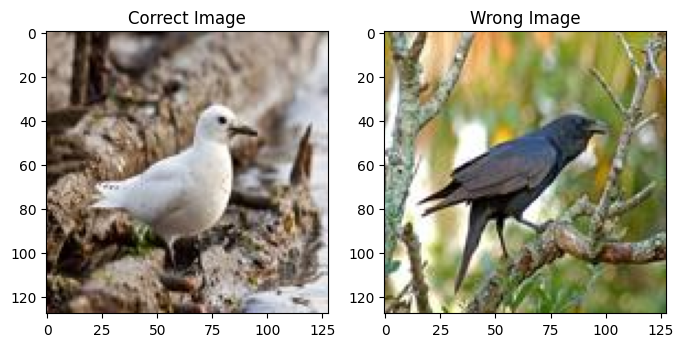

Sample 5 - Image: Green_Kingfisher_0015_71042_1.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


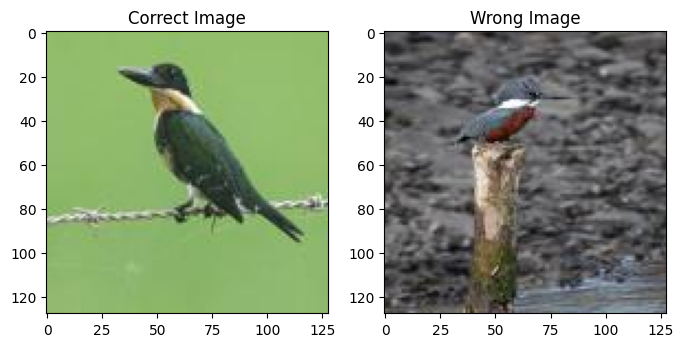

In [8]:
# Verify the dataset
verify_dataset(dls.train_ds, num_samples=5)

### GAN Model and Training

In [9]:
def avg_flatten(x): return x.mean(0).view(1)

def AvgFlatten(): return Lambda(avg_flatten)  # now can pickle

In [10]:
def squeezer(in_dim, out_dim):
    return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

In [11]:
class Txt2ImgGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = basic_generator(out_size=128, n_channels=3)
        self.squeezer = squeezer(400, 128)
    
    def forward(self, embedding, fake_image=None):        
        em_s = self.squeezer(embedding.view(embedding.size(0), -1))
        em_s = em_s[:,:,None,None]
        em_noise = torch.cat([em_s, torch.randn(em_s.size(0),100,1,1).cuda()], 1)
        generated_image = self.generator(em_noise)
        print(f"Txt2ImgGenerator forward: embedding={embedding.shape}, generated_image={generated_image.shape}")
        return embedding, generated_image

In [12]:
class Txt2ImgCritic(nn.Module):
    def __init__(self):
        super().__init__()
        critic = basic_critic(in_size=128, n_channels=3)
        self.body = nn.Sequential(*list(critic.children())[:-2])
        self.head = nn.Sequential(nn.Conv2d(640, 1, 4, padding=0), 
                                  AvgFlatten())
        self.squeezer = squeezer(400, 128)
     
    def forward(self, embedding, image):
        print(f"Txt2ImgCritic.forward called with embedding.shape={embedding.shape} and image.shape={image.shape}")
        x = self.body(image)                     # (512,4,4)
        em_s = self.squeezer(embedding.view(embedding.size(0), -1)) 
        em_s = em_s[:,:,None,None]               # (128,1,1)
        em_s = em_s.repeat(1,1,4,4)              # (128,4,4)
        x = torch.cat([x, em_s], 1)              # (640,4,4)
        x = self.head(x)
        print(f"Txt2ImgCritic.forward: output shape x={x.shape}")
        return x


In [13]:
class Txt2ImgLoss(GANModule):    
    def __init__(self, gan_model):
        super().__init__()
        self.gan_model = gan_model

    def generator(self, output, *target):
        # output: (embedding, image)
        print(f"Txt2ImgLoss.generator called with output shapes: {output[0].shape}, {output[1].shape}")
        fake_pred = self.gan_model.critic(output[0], output[1])  # Ensure both embedding and image are passed
        return fake_pred.mean()

    def critic(self, real_pred, em_noise, wrong_img):
        fake = self.gan_model.generator(em_noise.requires_grad_(False))
        # fake: (embedding, fake image)
        print(f"Txt2ImgLoss.critic called with fake shapes: {fake[0].shape}, {fake[1].shape}")
        fake[1].requires_grad_(True)
        fake_pred = self.gan_model.critic(fake[0], fake[1])  # Ensure both embedding and fake image are passed
        return real_pred.mean() - fake_pred.mean()

In [14]:
class Txt2ImgGANTrainer(GANTrainer):    
    def on_backward_begin(self, last_loss, last_output, **kwargs):        
        last_loss = last_loss.detach().cpu()
        if self.gen_mode:
            self.smoothenerG.add_value(last_loss)
            self.glosses.append(self.smoothenerG.smooth)
            self.last_gen = last_output[1].detach().cpu()
            print(f"Txt2ImgGANTrainer: Generator mode, last_output[1].shape={last_output[1].shape}")
        else:
            self.smoothenerC.add_value(last_loss)
            self.closses.append(self.smoothenerC.smooth)
            print(f"Txt2ImgGANTrainer: Critic mode, last_output.shape={last_output}")


In [15]:
generator = Txt2ImgGenerator()
critic = Txt2ImgCritic()

In [16]:
gan = GANModule(generator, critic)
loss_func = Txt2ImgLoss(gan)
switcher = FixedGANSwitcher(n_crit=5, n_gen=1)

In [17]:
learn = Learner(dls, gan, loss_func=loss_func, 
                opt_func = Adam, wd=0.,
                cbs=[switcher], path='.')

In [18]:
trainer = Txt2ImgGANTrainer(learn, clip=0.01, show_img=True)
learn.gan_trainer = trainer
learn.add_cbs(trainer)
print(f"Learner initialized: {learn}")

Learner initialized: <fastai.learner.Learner object at 0x108c89610>


In [19]:
learn.fit(20, 1e-4)

/Users/devanshurana/Desktop/Projects/text2image-gan/.venv/lib/python3.12/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/Users/devanshurana/Desktop/Projects/text2image-gan/.venv/lib/python3.12/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/Users/devanshurana/Desktop/Projects/text2image-gan/.venv/lib/python3.12/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that 

epoch,train_loss,valid_loss,time


/Users/devanshurana/Desktop/Projects/text2image-gan/.venv/lib/python3.12/site-packages/fastai/learner.py:448: SyntaxWarning: invalid escape sequence '\R'
  e.args = [f"Custom classes or functions exported with your `Learner` not available in namespace.\Re-declare/import before loading:\n\t{e.args[0]}"]


TypeError: Txt2ImgCritic.forward() missing 1 required positional argument: 'image'